# Problem 2

A photon moving at speed 1 in the x-y plane starts at time $t = 0$ at
$(x, y) = (\frac{1}{2}, \frac{1}{10})$ heading due east. Around every integer lattice point
$(i, j)$ in the plane, a circular mirror of radius $ \frac{1}{3}$ has been erected. How
far from $(0, 0)$ is the photon at $ t = 10 $ ?

### Some geometry
Let the position of the photon be $ P = (p_x, p_y) $ with velocity $ \vec{v} = \langle v_x, v_y \rangle $, and suppose it is bouncing off a circle with center $ C = (c_x, c_y) $ with radius $r$.

We first find the intersection point of the photon and the circle. Since we have that the ray can be represented parametrically as $ r(t) = \langle p_x + v_x t, p_y + v_y t\rangle$, we can solve for the time that the ray intersections the circle $t_{\text{int}}$ as follows:

$$ \begin{align*}
(x - c_x)^2 &+ (y - c_y) ^ 2 = r^2 \\
&\implies (p_x + v_x t - c_x)^2 + (p_y + v_y t - c_y) ^ 2 = r^2 \\
&\implies t^2 \underbrace{(v_x^2 + v_y^2)}_{A} +  t \cdot \underbrace{ 2 (p_x v_x + p_y v_y - c_x v_x - c_y v_y)}_{B} + \underbrace{(c_x^2 + c_y^2 - 2 c_x p_x - 2 c_y p_y + p_x^2 + p_y^2 - r^2)}_{C} = 0 \\
&\implies t_{\text{int}} = \min\left(\frac{-B+(B^2-4AC)^{1/2}}{2A}, \frac{-B-(B^2-4AC)^{1/2}}{2A}\right)
\end{align*}
$$

Note: if this quadratic has 2 complex roots, then there are no intersection points

We thus can get the intersection point of the ray and the circular mirror $p_{\text{int}} = (p_x + v_x t_{\text{int}}, p_y + v_y   t_{\text{int}}) $

To get the velocity of the photon after reflection, let $\overrightarrow{Cp_{\text{int}}}$ be the vector from the center of the circle to the intersection point. Then, the initial velocity vector can be split up into a component parallel to $\overrightarrow{Cp_{\text{int}}}$ and a component perpendicular to $\overrightarrow{Cp_{\text{int}}}$ as follows:

$ \vec{v} = \vec{v_{\parallel}} + \vec{v_{\perp}}$

$ \vec{v_{\parallel}} = proj_{\overrightarrow{Cp_{int}}} \vec{v} = \frac{\vec{v} \cdot \overrightarrow{Cp_{int}}}{|\overrightarrow{Cp_{int}}|^2}   \overrightarrow{Cp_{int}} $

The reflected vector is thus $ \vec{v_{\perp}} - \vec{v_{\parallel}} = \vec{v} - 2 \frac{\vec{v} \cdot \overrightarrow{Cp_{int}}}{|\overrightarrow{Cp_{int}}|^2}   \overrightarrow{Cp_{int}} $

Let's code this (again, using `mpmath` for extended precision):

In [1]:
from mpmath import sqrt, mp, mpf
class Vector(list):
    def __add__(self, other):
        return Vector([self[i]+other[i] for i in range(len(self))])
    def __sub__(self, other):
        return Vector([self[i]-other[i] for i in range(len(self))])
    def __mul__(self,other):
        return Vector([self[i]*other for i in range(len(self))])
    def __repr__(self):
        return f"({','.join(map(str, self))})"
    def dot(self, other):
        return sum([self[i]*other[i] for i in range(len(self))])
    def norm(self):
        return sqrt(self.dot(self))
def reflect(P, v, C, r):
    px, py = P
    vx, vy = v
    cx, cy = C
    a = vx*vx + vy*vy
    b = 2*(px*vx+py*vy-cx*vx-cy*vy)
    c = cx*cx+cy*cy-2*cx*px-2*cy*py+px*px+py*py-r*r
    t1,t2 = (-b+sqrt(b*b-4*a*c))/(2*a), (-b-sqrt(b*b-4*a*c))/(2*a)
    potential_t = [t for t in (t1,t2) if t.imag == 0]
    if len(potential_t) == 0: return None # there is no intersection
    else: t_int = min(potential_t)
    p_int = (px+vx*t_int, py+vy*t_int)
    px, py = p_int
    ray = Vector([cx-px, cy-py]) # ray from center of circle to intersection point
    v = Vector(list(v))
    v_out = v - ray * (2*(v.dot(ray)/ray.dot(ray)))
    return (t_int, Vector(p_int), Vector(v_out))
# Sanity check: 
# let P = (5,0), v = (-1,0), C = (0,0), r = 2
assert reflect((5,0),(-1,0),(0,0),2) == (mpf(3), Vector([mpf(2),mpf(0)]), Vector([mpf(1),mpf(0)]))
# Test the case when there is no intersection
assert reflect((2,0),(0,-1),(0,0),1) == None

Now, once we get a new intersection point and new velocity, we need to find the next circular mirror that the photon will hit. We do this by stepping in the path of the ray until we get a hit. Our step size here will be 1/2 (i.e. each step, we travel a distance of 1/2)

In [2]:
from itertools import count
def get_next_hit(time_remaining, P, v):
    unit_v = v * (1/sqrt(v.dot(v)))
    step_v = v * mpf("0.5")
    for i in count(1):
        circle_center = list(map(round, P + step_v * i))
        reflection = reflect(P, v, circle_center, mpf("1/3"))
        if reflection:
            t_elapsed, P_int, v_out = reflection
            if t_elapsed > 0: return (time_remaining-t_elapsed, P_int, v_out)
def run(prec):
    mp.dps = prec
    time_remaining = mpf("10")
    P = Vector([mpf("1/2"),mpf("1/10")])
    v = Vector([1,0])
    hits = [(time_remaining,P,v)]
    while time_remaining > 0:
        hits.append(get_next_hit(time_remaining, P, v))
        time_remaining,P,v = hits[-1]
    t_final, P_final, v_final = hits[-2]
    return (P_final + v_final*t_final).norm()

In [3]:
%time run(100)

CPU times: user 12.6 ms, sys: 100 µs, total: 12.7 ms
Wall time: 12.7 ms


mpf('0.9952629194433541608903118094267216210294669227341543498032088580729861796228306320991749819479625411445')

Note that we need about 20 digits of working precision to get an answer with a precision of $ 10^{-10} $

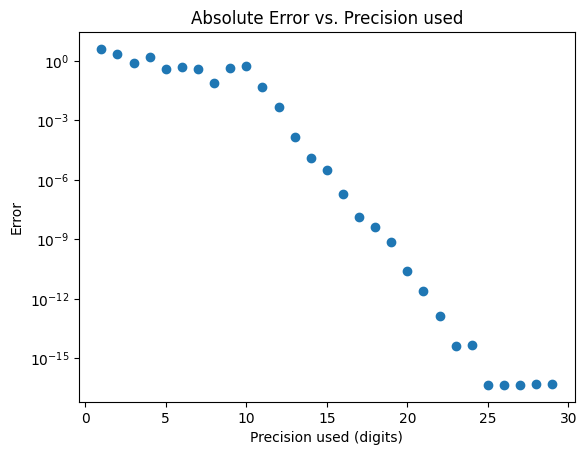

In [4]:
import matplotlib.pyplot as plt

ANSWER = float(run(100))

error = [abs(ANSWER - run(p)) for p in range(1, 30)]

plt.title("Absolute Error vs. Precision used")
plt.xlabel("Precision used (digits)")
plt.ylabel("Error")
ax = plt.gca()
ax.set_yscale('log')
plt.scatter(range(1,30), error)
plt.show()

As we can see from the plots below, it is very important for us to use high precision through the entire calculation process - otherwise the inaccuracies can compound rapidly.

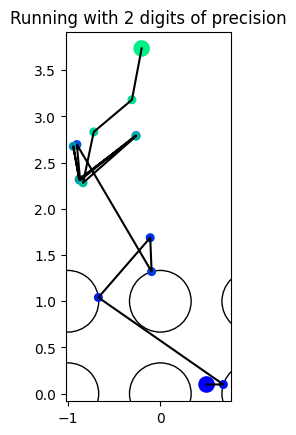

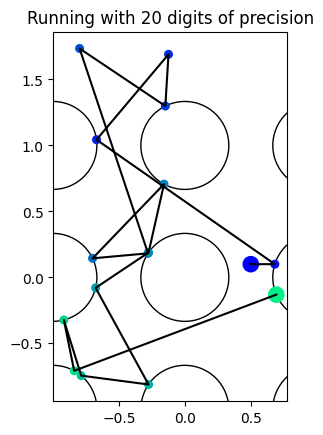

In [5]:
import matplotlib.pyplot as plt
from matplotlib import cm
# Generate the hits
def plot(prec):
    mp.dps = prec
    t = mpf("10")
    P = Vector([mpf("1/2"),mpf("1/10")])
    v = Vector([1,0])
    hits = [(t,P,v)]
    while t > 0:
        #print(t,P,v)
        hits.append(get_next_hit(t, P, v))
        t,P,v = hits[-1]
    hit_points = [i[1] for i in hits]
    fig, ax = plt.subplots()
    ax.set_aspect("equal")
    centers = [(x,y) for x in [-1,0,1] for y in [-1,0,1]]
    for c in centers:
        circle = plt.Circle(c, 1./3, fill=False)
        ax.add_artist(circle)
    plt.plot([i[0] for i in hit_points],[i[1] for i in hit_points], c = "black")
    plt.scatter([i[0] for i in hit_points],[i[1] for i in hit_points], 
                c = [cm.winter(i/len(hit_points)) for i in range(len(hit_points))], 
                s = [30 if i not in [0, len(hit_points)-1] else 120 for i in range(len(hit_points))])
    plt.title("Running with " + str(prec) + " digits of precision")
    plt.show()
plot(2)
plot(20)